# Cryptocurrency Twitter Classification

In this notebook, with our given data, we will try to apply classification methods to our data. Our goal is to see if it is possible to classify whether Bitcoin will rise or fall the next day given the current day's twitter statistics (namely (1) average likes of all tweets in the day, and (2) average hashtags of all tweets in the day).

First, we must import the needed modules

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import scipy as sp
import scipy.linalg as la
import io

## Final Data Uploading and wrangling
Upload the data we scraped separatley and do the final cleaning. We then combine the data and plot it, with green being that it rises, and red being that it falls.


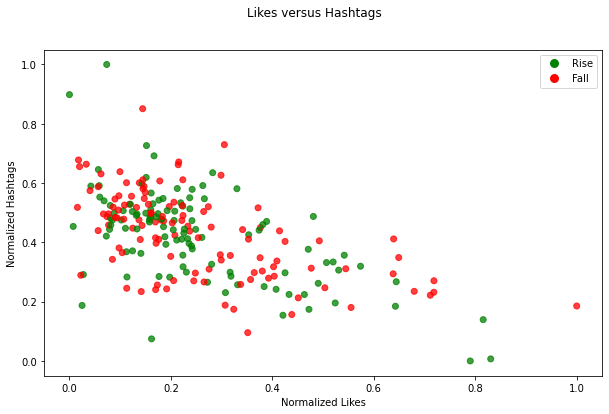

In [ ]:
# Import data from github
tweets = pd.read_csv('https://raw.githubusercontent.com/karansingh22/Crypto-Classification/main/normalized_tweets_wrangled.csv')
btc = pd.read_csv('https://raw.githubusercontent.com/karansingh22/Crypto-Classification/main/finalbtc.csv')

# Final data wrangling
tweets.drop(['Datetime', 'Verified?', 'Followers','Friends','Retweets','Replies','Tweet Length'], axis=1, inplace=True)
btc.drop(['Unnamed: 0'], axis=1, inplace=True)
btc['Rise?'] = btc['Rise?'].apply(lambda val: int(val))
combined_data = pd.DataFrame(np.append(tweets,btc,axis=1), columns=['likes','hashtags', 'rise'])

# Create nd.arrays for ease of computation
X = tweets.to_numpy()
X0 = (combined_data[combined_data['rise']==0]).drop(['rise'],axis=1).to_numpy()
X1 = (combined_data[combined_data['rise']==1]).drop(['rise'],axis=1).to_numpy()
Y = btc.to_numpy()

# Plot the points, grouped by color
fig, ax = plt.subplots(figsize=(10,6))
colors = {1:'green', 0:'red'}
x = ax.scatter(combined_data['likes'], combined_data['hashtags'], c=combined_data['rise'].map(colors), alpha=0.75)
fig.suptitle('Likes versus Hashtags')
plt.xlabel('Normalized Likes')
plt.ylabel('Normalized Hashtags')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rise', markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Fall', markerfacecolor='r', markersize=10)]
ax.legend(handles=legend_elements)
plt.show()

## Maximum Likelihood
In this part build a two-class classifier by using Maximum Likelihood to estimate the parameters of the generative model (namely each class's mean and the Covariance matrix). We find the values of the needed parameters by using the maximum likelihood solution to likelihood.<br>$$(\mu_{\hat{0}, j})_{ML}=\frac{\sum_{i:y_i=0}^{}x_{i,j}}{\sum(1-y_i)}\\
(\mu_{\hat{1}, j})_{ML}=\frac{\sum_{i:y_i=1}^{}x_{i,j}}{\sum(y_i)}\\(\hat{\sigma^2_j})_{ML}=\frac{1}{n}\left(\sum_{i:y_i=0}(x_{i,j}-\hat{\mu_{0,j}})^2+\sum_{i:y_i=1}(x_{i,j}-\hat{\mu_{1,j}})^2\right)$$ 

<br>Once we have done this, we then calculate and plot the decision boundary on the graph using the given data.

In [ ]:
#Calculate mean ML for a given class
def mu(cls):
  m = [0,0]
  for j in range(2):
    sumn = 0
    for i in range(int(len(X))):
      if Y[i] == cls:
        sumn += float(X[i][j])
    sumd = 0
    if cls == 0:
      sumd = int(len(Y)) - int(sum(Y))
    else:
      sumd = int(sum(Y))
    m[j] = sumn/sumd
  return m   

# Calculate the sigma^s diagonal matrix for the data
def sigma():
  sigmas = [[0,0],[0,0]]
  for j in range(2):
    val = 1/float(len(Y))

    sum0 = 0
    sum1 = 0

    for i in range(int(len(Y))):
      if Y[i] == 0:
        sum0 += float((X[i][j] - m0_ML[j])**2)
      else:
        sum1 += float((X[i][j] - m1_ML[j])**2)
    sigmas[j][j] = val*(sum0 + sum1)
  return sigmas


pi_ML = sum(Y)/len(Y)
m0_ML = np.array(mu(0))
m1_ML = np.array(mu(1))
sigma_ML = np.array(sigma())


print("pi =", pi_ML[0])
print("mu_0 =", m0_ML)
print("mu_1 =", m1_ML)
print("Sigma:", sigma_ML)

pi = 0.4845814977973568
mu_0 = [0.24958121 0.42987698]
mu_1 = [0.24939026 0.42455627]
Sigma: [[0.03075739 0.        ]
 [0.         0.02229724]]


Calculate the $\beta$ and $\gamma$ parameters of the decision boundary using the maximum likelihood estimates and then plot.<br><br>
$$\text{Decision Boundary:  } \boldsymbol{\beta}^T\boldsymbol{x}+\gamma=0\text{, where:}\\\boldsymbol{\beta}^T=(\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0)^T\Sigma^{-1}\\\gamma = ln\frac{\pi}{1-\pi}-\frac{1}{2}(\boldsymbol{\mu}_1-\boldsymbol{\mu}_0)^T\Sigma^{-1}(\boldsymbol{\mu}_1+\boldsymbol{\mu}_0)$$

Theta: [-0.006208262922460372, -0.23862614072345711, 0.04180035873024408]


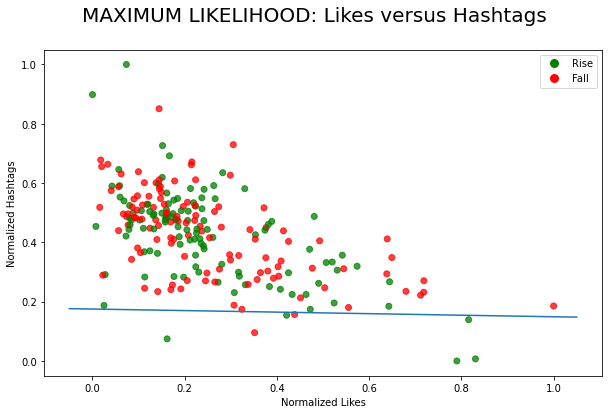

In [ ]:
#Solution for classifier based on ML estimates
betaML = np.dot((m1_ML - m0_ML).transpose(), np.linalg.inv(sigma_ML))
gammaML = float(np.log(pi_ML/(1-pi_ML)) - 0.5*(np.dot(np.dot((m1_ML - m0_ML).transpose(), np.linalg.inv(sigma_ML)), (m1_ML + m0_ML))))
thetaML = [betaML[0],betaML[1],gammaML]
print("Theta:",thetaML)

# Plot the line
fig, ax = plt.subplots(figsize=(10,6))
colors = {1:'green', 0:'red'}
x = ax.scatter(combined_data['likes'], combined_data['hashtags'], c=combined_data['rise'].map(colors), alpha=0.75)
plt.suptitle('MAXIMUM LIKELIHOOD: Likes versus Hashtags',fontsize=20)
plt.xlabel('Normalized Likes')
plt.ylabel('Normalized Hashtags')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rise', markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Fall', markerfacecolor='r', markersize=10)]

x0_range = np.array(ax.get_xlim())
x1_range = [(-thetaML[2] - thetaML[0]*a)/thetaML[1] for a in x0_range]
ax.plot(x0_range, x1_range)
ax.legend(handles=legend_elements)
plt.show()


## Gradient Descent for Logistic Regression
Now, we assume a logistic regression model. First, we modify the existing data points and add a 1 to each for easy computation. Then we will use gradient descent to minimize the loss of the negative log-likelihood loss, which is given by:<br><br> $$\mathfrak{L}(\boldsymbol{\beta}, \gamma) = \sum_{i=1}^{n}\left(y_i\; ln\frac{1}{h(\textbf{x}_i)}\;+\;(1-y_i)\; ln\frac{1}{1-h(\textbf{x}_i)}\right)$$
<br>
For simplicity, we let<br><br>
$$\boldsymbol{\theta} = \binom{\boldsymbol{\beta}}{\gamma}, \;\; \tilde{\textbf{x}}=\binom{\textbf{x}}{1}, \;\; h_{\boldsymbol{\theta}}= p(y=1|\textbf{x}) = \frac{1}{1+e^{-\theta^T\tilde{x}}}$$
<br>
We can then use gradient descent to optimize the values for $\theta$ with 1000 iterations, and $\rho = 0.001$ using the gradient descent formula:<br><br>
$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)}+\rho_t\nabla_{\boldsymbol{\theta}}\mathfrak{L}(\boldsymbol{\theta})$$ where $$\nabla_{\boldsymbol{\theta}}\mathfrak{L}(\boldsymbol{\theta}) = \sum_{i=1}^{n}(y_i - h_{\boldsymbol{\theta}}(\tilde{\textbf{x}}_i))\tilde{\textbf{x}}_i$$ represents the gradient of the negative log-likelihood loss function.

[-0.05286232 -0.17571995  0.02554808]


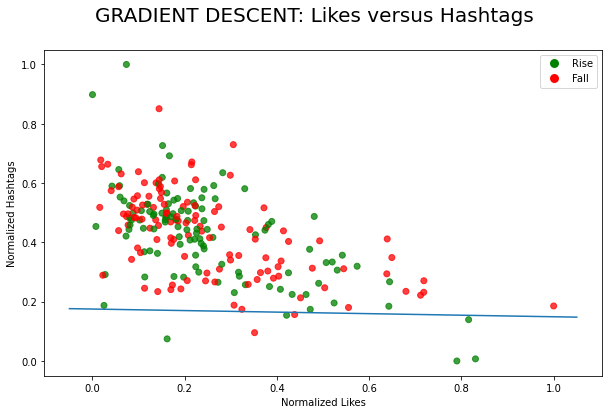

In [ ]:
T = 1000 # iterations
ones = np.array([1]*len(X))[:,None] # column vector consisting of 1s
X_ = np.concatenate((X,ones),axis=1)
theta = np.zeros((T,3))
theta[0] = [0,0,0]
rho = 0.001 # step size

# This represents the gradient of the negative log-likelihood loss function at a given time period
def grad_loss(t):
  sum = 0
  for i in range(227):
    sum += np.dot(int(Y[i]) - (1/(1 + np.exp(np.negative(np.dot(t.transpose(), X_[i]))))),X_[i])
  return sum

# This is the actual gradient descent; it records theta at every iteration
for i in range(999):
  theta[i+1] = theta[i] + rho*grad_loss(theta[i])
  
# Save the final theta at the end of the 1000 iterations.
thetaGD = theta[999]

# Plot the Decision boundary
print(thetaGD)
fig, ax = plt.subplots(figsize=(10,6))
colors = {1:'green', 0:'red'}
x = ax.scatter(combined_data['likes'], combined_data['hashtags'], c=combined_data['rise'].map(colors), alpha=0.75)
plt.suptitle('GRADIENT DESCENT: Likes versus Hashtags',fontsize=20)
plt.xlabel('Normalized Likes')
plt.ylabel('Normalized Hashtags')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rise', markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Fall', markerfacecolor='r', markersize=10)]

x0_range = np.array(ax.get_xlim())
x1_range = [(-thetaML[2] - thetaML[0]*a)/thetaML[1] for a in x0_range]
ax.plot(x0_range, x1_range)
ax.legend(handles=legend_elements)
plt.show()

## Stochastic Gradient Descent for Logistic Regression

We once again assume a logistic regression model. Using the same strategy as above, we optimize the value of $\theta$, but this time we randomly select a data point when calculating the gradient of the loss.

[-0.00520785 -0.00840295 -0.01893347]


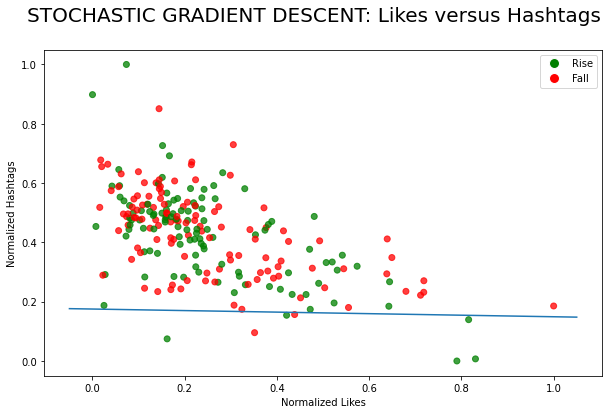

In [ ]:
T = 1000
ones = np.array([1]*len(X))[:,None] # column vector consisting of 1s
X_ = np.concatenate((X,ones),axis=1)
theta = np.zeros((T,3))
theta[0] = [0,0,0]
rho = 0.001

# Stochastic gradient loss function
def grad_loss(t):
  n = np.random.randint(227)
  return np.dot(int(Y[n]) - (1/(1 + np.exp(np.negative(np.dot(t.transpose(), X_[n]))))),X_[n])

# Stochastic gradient descent
for i in range(999):
  theta[i+1] = theta[i] + rho*grad_loss(theta[i])
  
# Final value of parameters from stochastic gradient descent
thetaGD = theta[999]

# Plot the decision boundary
print(thetaGD)
fig, ax = plt.subplots(figsize=(10,6))
colors = {1:'green', 0:'red'}
x = ax.scatter(combined_data['likes'], combined_data['hashtags'], c=combined_data['rise'].map(colors), alpha=0.75)
plt.suptitle('STOCHASTIC GRADIENT DESCENT: Likes versus Hashtags',fontsize=20)
plt.xlabel('Normalized Likes')
plt.ylabel('Normalized Hashtags')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rise', markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Fall', markerfacecolor='r', markersize=10)]

x0_range = np.array(ax.get_xlim())
x1_range = [(-thetaML[2] - thetaML[0]*a)/thetaML[1] for a in x0_range]
ax.plot(x0_range, x1_range)
ax.legend(handles=legend_elements)
plt.show()

## Discussion

Regardless of the strategy chosen to determine the decision boundary, it is clear that this data either is not fit to the model we subjected it to, or cannot be classified. The latter seems more likely, as it makes sense that you cannot determine a cryptocurrency's trajectory based of of hashtags and likes of tweets containing keywords of that cryptocurrency. Also, the data does not seem to be linearly separable.